In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

import wandb

In [4]:
# Gedanken: Wir möchten den CIFAR-10 Datensatz laden, ohne Augmentation, um grundlegende Eigenschaften zu untersuchen.
# Nur Tensor-Konvertierung für die EDA
transform_eda = ToTensor()
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform_eda)
train_loader_eda = DataLoader(cifar10_train, batch_size=64, shuffle=False)

print(f"Anzahl Trainingsbeispiele: {len(cifar10_train)}")
print(f"Klassen: {cifar10_train.classes}")

Anzahl Trainingsbeispiele: 50000
Klassen: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


airplane  : 5000
automobile: 5000
bird      : 5000
cat       : 5000
deer      : 5000
dog       : 5000
frog      : 5000
horse     : 5000
ship      : 5000
truck     : 5000


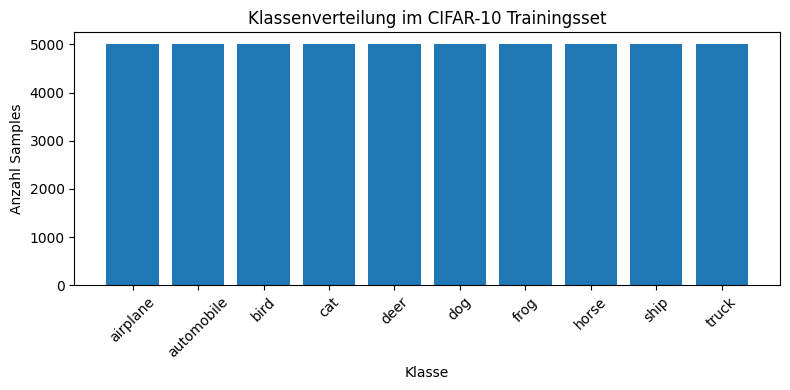

In [5]:
# Gedanken: Wir zählen die Anzahl der Beispiele pro Klasse, um die Balance zu bewerten.
class_counts = [0] * len(cifar10_train.classes)
for _, label in cifar10_train:
    class_counts[label] += 1

for cls, count in zip(cifar10_train.classes, class_counts):
    print(f"{cls:10s}: {count}")

# Bar-Plot der Verteilung\import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(cifar10_train.classes, class_counts)
plt.title('Klassenverteilung im CIFAR-10 Trainingsset')
plt.xlabel('Klasse')
plt.ylabel('Anzahl Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

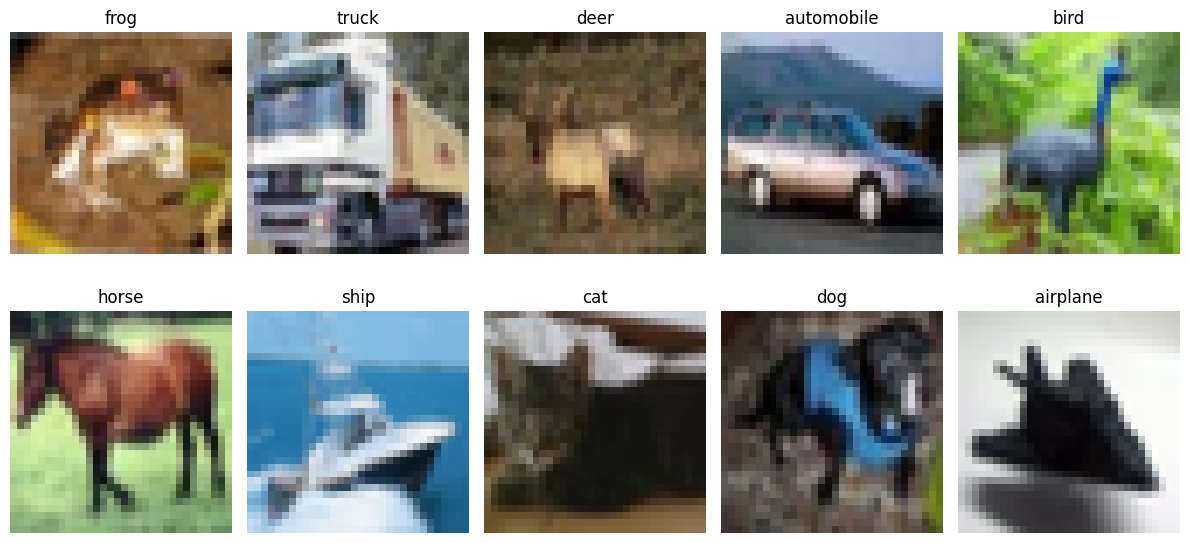

In [7]:
grid_imgs = []
grid_titles = []
seen = {i: False for i in range(len(cifar10_train.classes))}
for img, label in cifar10_train:
    if not seen[label]:
        grid_imgs.append(img)
        grid_titles.append(cifar10_train.classes[label])
        seen[label] = True
    if all(seen.values()):
        break

# Darstellung
plt.figure(figsize=(12,6))
for i, (img, title) in enumerate(zip(grid_imgs, grid_titles)):
    plt.subplot(2, 5, i+1)
    imshow(img, title)
plt.tight_layout()
plt.show()

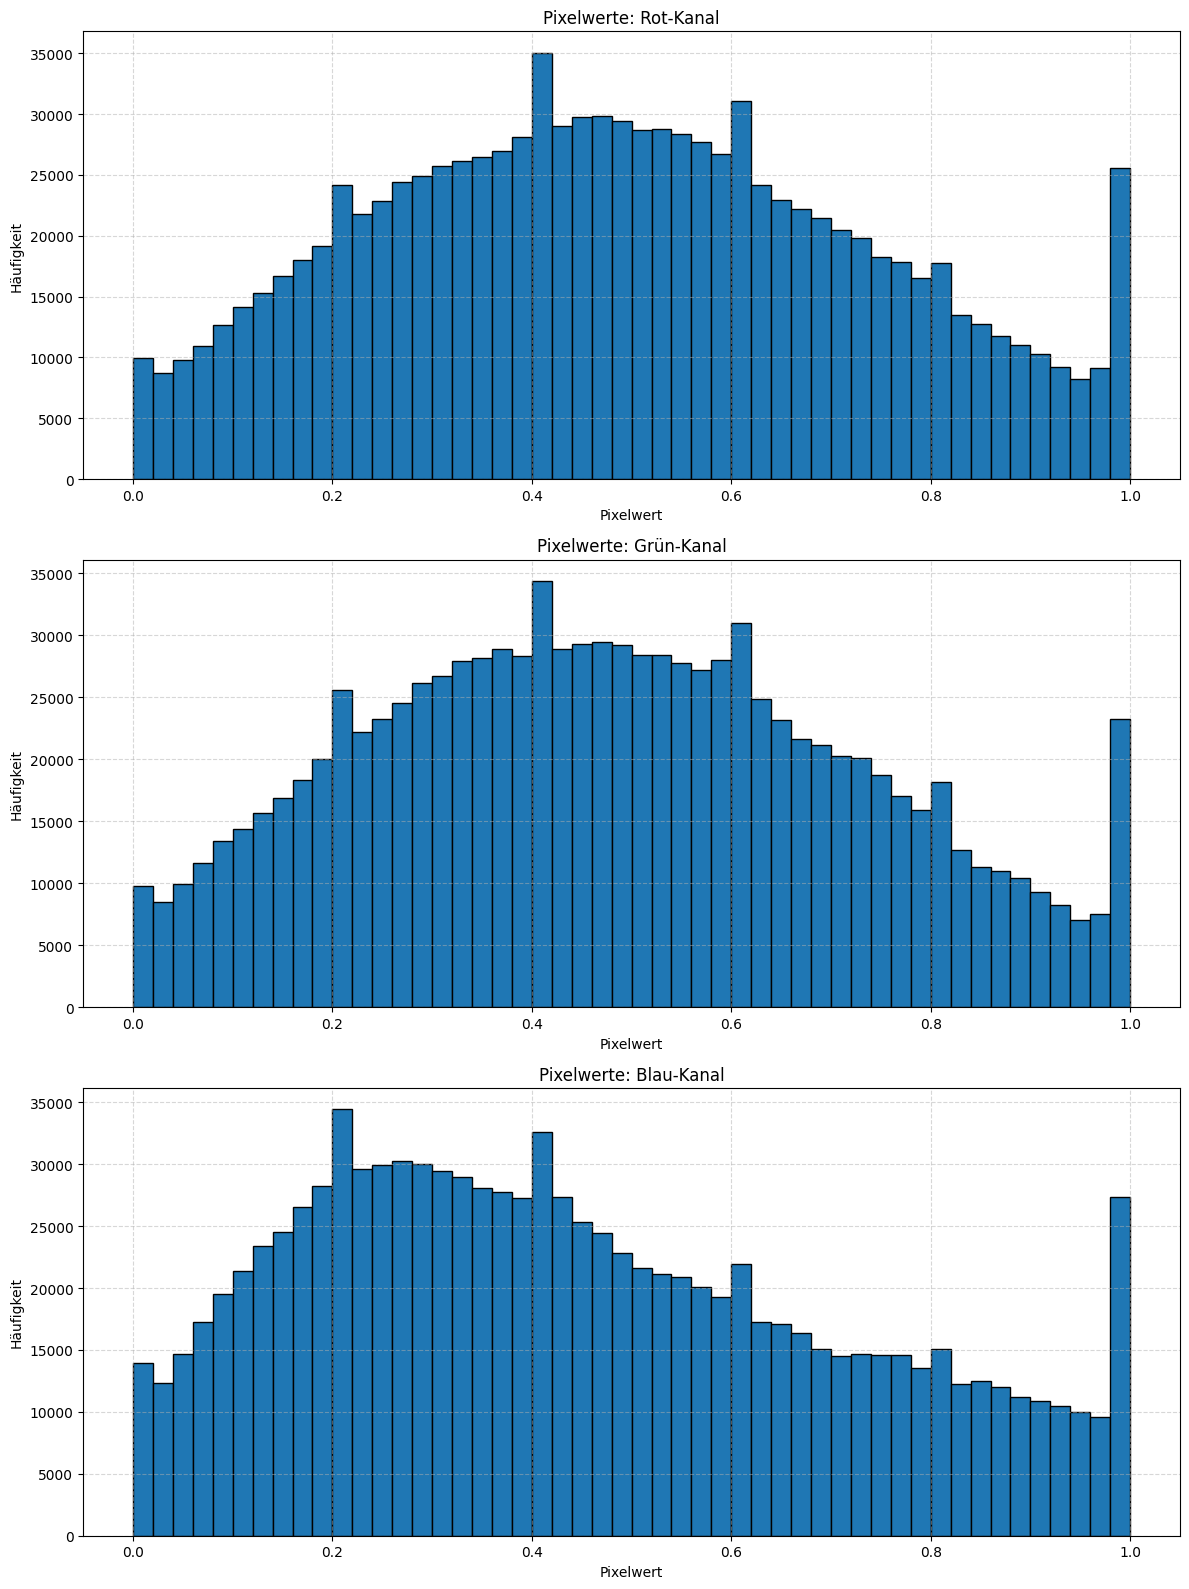

In [25]:
# Kanalweise Pixelwerte sammeln
to_collect = {'Rot': [], 'Grün': [], 'Blau': []}
for i in range(1000):
    img, _ = cifar10_train[i]
    to_collect['Rot'].append(img[0].view(-1))
    to_collect['Grün'].append(img[1].view(-1))
    to_collect['Blau'].append(img[2].view(-1))

# Zusammenführen der Pixelwerte pro Kanal
pixels = {chan: torch.cat(vals).numpy() for chan, vals in to_collect.items()}

# Plot in separaten Subplots
fig, axes = plt.subplots(3, 1, figsize=(12,16))
for ax, (chan, data) in zip(axes, pixels.items()):
    ax.hist(data, bins=50, edgecolor='black')
    ax.set_title(f'Pixelwerte: {chan}-Kanal')
    ax.set_xlabel('Pixelwert')
    ax.set_ylabel('Häufigkeit')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [26]:
loader_stats = DataLoader(cifar10_train, batch_size=5000, shuffle=False, num_workers=2)
# Ein Batch enthält 5000 Bilder (d.h. 10 Elemente für 50000 Bilder)
all_means = []
all_stds  = []
for imgs, _ in loader_stats:
    # imgs-Form: (Batch, Channels, H, W)
    all_means.append(imgs.mean(dim=[0,2,3]))
    all_stds.append(imgs.std(dim=[0,2,3]))
mean = torch.stack(all_means).mean(dim=0)
std  = torch.stack(all_stds).mean(dim=0)
print(f"Berechnete mean: {mean.tolist()}")
print(f"Berechnete std : {std.tolist()}")

Berechnete mean: [0.49139919877052307, 0.4821583330631256, 0.446530818939209]
Berechnete std : [0.247023344039917, 0.24347808957099915, 0.2615787386894226]


In [17]:
# Standardwerte für CIFAR-10
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

print("Preprocessing-Transforms sind definiert.")

Preprocessing-Transforms sind definiert.


---

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# Hyperparameter
epochs = 30
batch_size = 16
learning_rate = 0.001
project_name = "image-classification"
run_name = "baseline_cnn"

In [30]:
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "BaselineCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oliver-pejic (oliver-pejic-fachhochschule-nordwestschweiz-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [31]:
# Transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [32]:
# Datensätze
cifar10_train_full = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
cifar10_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

100%|██████████| 170M/170M [00:15<00:00, 11.3MB/s] 


In [33]:
# Split in Training/Validation
train_len = int(0.85 * len(cifar10_train_full))
val_len   = len(cifar10_train_full) - train_len
train_ds, val_ds = random_split(
    cifar10_train_full,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

# DataLoader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(cifar10_test)}")
print("Classes:", cifar10_train_full.classes)

Train/Val/Test sizes: 42500/7500/10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


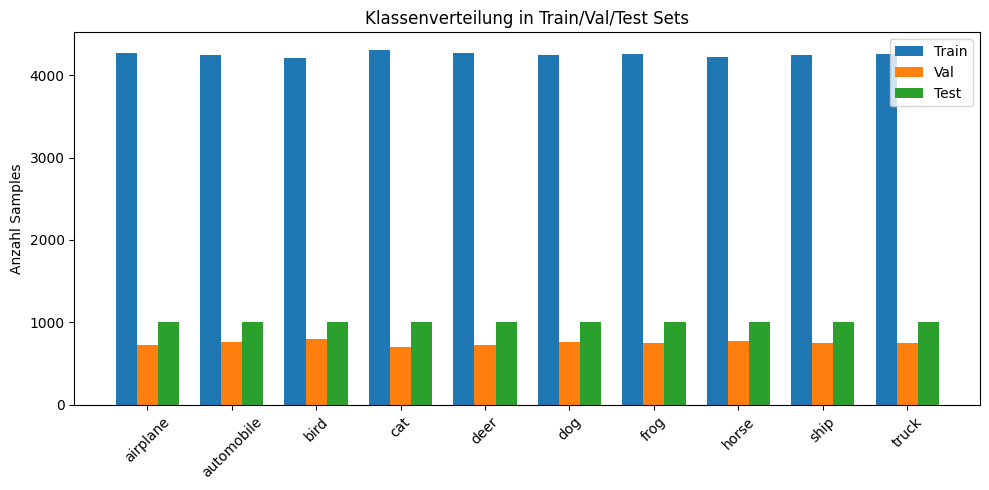

In [35]:
# Labels extrahieren
train_labels = [label for _, label in train_ds]
val_labels   = [label for _, label in val_ds]
test_labels  = cifar10_test.targets  # bereits Liste

# Zähle pro Klasse
classes = cifar10_train_full.classes
counts_train = [Counter(train_labels)[i] for i in range(len(classes))]
counts_val   = [Counter(val_labels)[i]   for i in range(len(classes))]
counts_test  = [Counter(test_labels)[i]  for i in range(len(classes))]

# Gruppiertes Balkendiagramm
x = np.arange(len(classes))
width = 0.25
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - width, counts_train, width, label='Train')
ax.bar(x,         counts_val,   width, label='Val')
ax.bar(x + width, counts_test,  width, label='Test')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.set_ylabel('Anzahl Samples')
ax.set_title('Klassenverteilung in Train/Val/Test Sets')
ax.legend()
plt.tight_layout()
plt.show()

In [36]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(cifar10_train_full.classes)
model = BaselineCNN(num_classes).to(device)
wandb.watch(model, log="all", log_freq=10)
print(model)

BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [41]:
def train_one_epoch(model, loader, criterion, optimizer, epoch=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds    = outputs.max(1)
        correct    += (preds == labels).sum().item()
        total      += labels.size(0)
    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total
    if epoch is not None:
        wandb.log({"train_loss": epoch_loss, "train_accuracy": epoch_acc, "epoch": epoch})
    return epoch_loss, epoch_acc

def eval_one_epoch(model, loader, criterion, epoch=None, split_name="val"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds     = outputs.max(1)
            correct      += (preds == labels).sum().item()
            total        += labels.size(0)
    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total
    if epoch is not None:
        wandb.log({f"{split_name}_loss": epoch_loss, f"{split_name}_accuracy": epoch_acc, "epoch": epoch})
    return epoch_loss, epoch_acc

def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses,   label="Val Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label="Train Acc")
    plt.plot(epochs_range, val_accs,   label="Val Acc")
    plt.title("Accuracy Curves")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [40]:
# Gedanken: Überprüfen, ob das Modell ein einzelnes Sample komplett lernen kann (sanity check).
ov_model = BaselineCNN(num_classes).to(device)
criterion_ov = nn.CrossEntropyLoss()
optimizer_ov = optim.SGD(ov_model.parameters(), lr=0.01, momentum=0.9)

# Ein Sample aus dem Trainingsset
sample_img, sample_lbl = train_ds[0]
sample_img = sample_img.unsqueeze(0).to(device)
sample_lbl = torch.tensor([sample_lbl], dtype=torch.long).to(device)

print(">>> Single-Sample Overfitting Test:")
for epoch in range(1, 21):
    ov_model.train()
    optimizer_ov.zero_grad()
    out   = ov_model(sample_img)
    loss  = criterion_ov(out, sample_lbl)
    loss.backward()
    optimizer_ov.step()
    _, pred = out.max(1)
    acc     = 100 * (pred == sample_lbl).float().item()
    print(f"Epoch {epoch:02d}: Loss={loss.item():.4f}, Acc={acc:.1f}%")

>>> Single-Sample Overfitting Test:
Epoch 01: Loss=2.2754, Acc=0.0%
Epoch 02: Loss=2.1299, Acc=100.0%
Epoch 03: Loss=1.9136, Acc=100.0%
Epoch 04: Loss=1.5994, Acc=100.0%
Epoch 05: Loss=1.0723, Acc=100.0%
Epoch 06: Loss=0.3544, Acc=100.0%
Epoch 07: Loss=0.0254, Acc=100.0%
Epoch 08: Loss=0.0005, Acc=100.0%
Epoch 09: Loss=0.0000, Acc=100.0%
Epoch 10: Loss=0.0000, Acc=100.0%
Epoch 11: Loss=0.0000, Acc=100.0%
Epoch 12: Loss=0.0000, Acc=100.0%
Epoch 13: Loss=0.0000, Acc=100.0%
Epoch 14: Loss=0.0000, Acc=100.0%
Epoch 15: Loss=0.0000, Acc=100.0%
Epoch 16: Loss=0.0000, Acc=100.0%
Epoch 17: Loss=0.0000, Acc=100.0%
Epoch 18: Loss=0.0000, Acc=100.0%
Epoch 19: Loss=0.0000, Acc=100.0%
Epoch 20: Loss=0.0000, Acc=100.0%


In [ ]:
# Gedanken: Training des Basismodells über alle Epochen, Tracking mit W&B und Sammeln der Learning Curves.
model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(">>> Training on CIFAR-10 train/val starts ...")
for ep in range(1, epochs + 1):
    tl, ta = train_one_epoch(model, train_loader, criterion, optimizer, epoch=ep)
    vl, va = eval_one_epoch(model, val_loader, criterion, epoch=ep, split_name="val")

    train_losses.append(tl)
    train_accs.append(ta)
    val_losses.append(vl)
    val_accs.append(va)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Learning Curves plotten
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

In [ ]:
def compute_metrics(model, loader):
    all_lbls, all_preds = [], []
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outs = model(imgs)
            _, preds = outs.max(1)
            all_lbls.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())
    p = precision_score(all_lbls, all_preds, average="macro")
    r = recall_score(all_lbls, all_preds, average="macro")
    f = f1_score(all_lbls, all_preds, average="macro")
    return p, r, f

precision, recall, f1 = compute_metrics(model, test_loader)
_, test_acc = eval_one_epoch(model, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc:.1f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

In [ ]:
cifar10_train_for_cv = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=False, transform=transform_test
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accs = []
print(">>> 5-Fold CV on entire CIFAR-10 train set starts ...")

for fold, (tr_idx, va_idx) in enumerate(kf.split(cifar10_train_for_cv), start=1):
    tr_ds = Subset(cifar10_train_for_cv, tr_idx)
    va_ds = Subset(cifar10_train_for_cv, va_idx)
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    m_cv = BaselineCNN(num_classes).to(device)
    opt = optim.SGD(m_cv.parameters(), lr=learning_rate, momentum=0.9)
    crit = nn.CrossEntropyLoss()

    # Kurzes Training pro Fold (5 Epochen)
    for _ in range(5):
        train_one_epoch(m_cv, tr_ld, crit, opt, epoch=None)
    _, acc = eval_one_epoch(m_cv, va_ld, crit, epoch=None, log_to_wandb=False, split_name="cv")
    fold_accs.append(acc)
    print(f"Fold {fold}: Val Acc = {acc:.2f}%")

mean_acc = np.mean(fold_accs)
std_acc  = np.std(fold_accs)

print(f"CV Results: Mean = {mean_acc:.2f}%, Std = {std_acc:.2f}%")

In [ ]:
# Balkendiagramm der Fold-Accuracies
plt.figure(figsize=(8,5))
plt.bar(range(1,6), fold_accs, edgecolor='black')
plt.axhline(y=mean_acc, linestyle='--', color='red', label=f'Mean = {mean_acc:.2f}%')
plt.title('5-Fold Cross-Validation Accuracies')
plt.xlabel('Fold Number')
plt.ylabel('Validation Accuracy (%)')
plt.xticks(range(1,6))
plt.legend()
plt.tight_layout()
plt.show()

---

# Schritt 4: Hyperparameter Tuning

In diesem Schritt formulieren wir 10 Hypothesen aus den vorgegebenen Gruppen, führen Experimente durch und reflektieren die Ergebnisse.

## 4.1 Hypothese 1: Kleinere Lernrate (SGD)

Erwartung: Reduzierte Lernrate (0.001 vs. 0.0001) führt zu langsamerem, aber stabilerem Abfall des Trainingsverlusts und ggf. besserer Validierungsaccuracy.

In [42]:
lr_small = 0.0001

# W&B Init für Hypothese 1
wandb.init(
    project=project_name,
    name="hypothesis1_lower_lr",
    config={"hypothesis": "lower_lr",
            "learning_rate": lr_small,
            "epochs": epochs,
            "batch_size": batch_size}
)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [ ]:
model_lr = BaselineCNN(num_classes).to(device)
wandb.watch(model_lr, log="all", log_freq=10)
optimizer_lr = optim.SGD(model_lr.parameters(), lr=lr_small, momentum=0.9)


train_losses_lr, val_losses_lr = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_lr, train_loader, criterion, optimizer_lr, epoch=ep)
    vl, va = eval_one_epoch(model_lr, val_loader, criterion, epoch=ep)
    train_losses_lr.append(tl)
    val_losses_lr.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Baseline vs. small lr
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline L=0.01')
plt.plot(range(1, epochs+1), train_losses_lr, label='L=0.001')
plt.title('Train Loss: lr 0.01 vs 0.001')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test-Metriken berechnen und loggen
precision_lr, recall_lr, f1_lr = compute_metrics(model_lr, test_loader)
_, test_acc_lr = eval_one_epoch(model_lr, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_lr,
    "test_precision": precision_lr,
    "test_recall": recall_lr,
    "test_f1_score": f1_lr
})

## 4.2 Hypothese 2: Xavier-Gewichtsinitialisierung

Erwartung: Xavier-Initialisierung verbessert die Gradientenverteilung und beschleunigt das Training gegenüber der Standard(initialisierung).

In [43]:
def init_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
# W&B Init für Hypothese 2
wandb.init(
    project=project_name,
    name="hypothesis2_xavier_init",
    config={"hypothesis": "xavier_init",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
# Modell und Optimizer
model_xav = BaselineCNN(num_classes).to(device)
model_xav.apply(init_weights_xavier)
wandb.watch(model_xav, log="all", log_freq=10)
optimizer_xav = optim.SGD(model_xav.parameters(), lr=learning_rate, momentum=0.9)

train_losses_xav, val_losses_xav = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_xav, train_loader, criterion, optimizer_xav, epoch=ep)
    vl, va = eval_one_epoch(model_xav, val_loader, criterion, epoch=ep)
    train_losses_xav.append(tl)
    val_losses_xav.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. Xavier
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Init')
plt.plot(range(1, epochs+1), train_losses_xav, label='Xavier Init')
plt.title('Train Loss: Standard vs. Xavier Init')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()
plt.show()


In [ ]:
# Test-Metriken berechnen und loggen
precision_xav, recall_xav, f1_xav = compute_metrics(model_xav, test_loader)
_, test_acc_xav = eval_one_epoch(model_xav, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_xav,
    "test_precision": precision_xav,
    "test_recall": recall_xav,
    "test_f1_score": f1_xav
})

## 4.3 Hypothese 3: Erhöhte Modelltiefe

Erwartung: Mehr Convolutional-Layer (ExtendedCNN) kann bessere Features extrahieren, erhöht aber Overfitting-Risiko.

In [44]:
class ExtendedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # neues Layer
        self.fc1   = nn.Linear(128 * 4 * 4, 256)  # Achtung: räumliche Dimension halbiert sich dreimal
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(torch.relu(self.conv3(x)))  # [B, 128, 4, 4]
        x = x.view(x.size(0), -1)                  # [B, 128*4*4]
        x = torch.relu(self.fc1(x))                # [B, 256]
        return self.fc2(x)

In [ ]:
wandb.init(
    project=project_name,
    name="hypothesis3_deeper_model",
    config={"hypothesis": "deeper_model",
            "model": "ExtendedCNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
model_ext = ExtendedCNN(num_classes).to(device)
wandb.watch(model_ext, log="all", log_freq=10)
optimizer_ext = optim.SGD(model_ext.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
train_losses_ext, val_losses_ext = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_ext, train_loader, criterion, optimizer_ext, epoch=ep)
    vl, va = eval_one_epoch(model_ext, val_loader, criterion, epoch=ep)
    train_losses_ext.append(tl)
    val_losses_ext.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. Extended
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Model')
plt.plot(range(1, epochs+1), train_losses_ext, label='Extended Model')
plt.title('Train Loss: Standard vs. Extended Model')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()
plt.show()



In [ ]:
# Test-Metriken berechnen und loggen
precision_ext, recall_ext, f1_ext = compute_metrics(model_ext, test_loader)
_, test_acc_ext = eval_one_epoch(model_ext, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_ext,
    "test_precision": precision_ext,
    "test_recall": recall_ext,
    "test_f1_score": f1_ext
})

## 4.4 Hypothese 4: Erhöhte Modellbreite

Erwartung: Mehr Filter (FilteredCNN) verbessert Feature-Repräsentation, steigert aber Parameternzahl.

In [45]:
class FilteredCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # statt 32 nun 64 Filter
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # statt 64 nun 128 Filter
        self.fc1   = nn.Linear(128 * 8 * 8, 256)  # mehr Feature-Maps, also Größe anpassen
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 64, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 128, 8, 8]
        x = x.view(x.size(0), -1)                  # [B, 128*8*8]
        x = torch.relu(self.fc1(x))                # [B, 256]
        return self.fc2(x)

In [ ]:
# W&B Init für Hypothese 4
wandb.init(
    project=project_name,
    name="hypothesis4_wider_model",
    config={"hypothesis": "wider_model",
            "model": "FilteredCNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
model_filt = FilteredCNN(num_classes).to(device)
wandb.watch(model_filt, log="all", log_freq=10)
optimizer_filt = optim.SGD(model_filt.parameters(), lr=learning_rate, momentum=0.9)

train_losses_filt, val_losses_filt = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_filt, train_loader, criterion, optimizer_filt, epoch=ep)
    vl, va = eval_one_epoch(model_filt, val_loader, criterion, epoch=ep)
    train_losses_filt.append(tl)
    val_losses_filt.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. Filtered
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Model')
plt.plot(range(1, epochs+1), train_losses_filt, label='Filtered Model')
plt.title('Train Loss: Standard vs. Filtered Model')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()
plt.show()

In [ ]:
# Test-Metriken berechnen und loggen
precision_filt, recall_filt, f1_filt = compute_metrics(model_filt, test_loader)
_, test_acc_filt = eval_one_epoch(model_filt, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_filt,
    "test_precision": precision_filt,
    "test_recall": recall_filt,
    "test_f1_score": f1_filt
})

## 4.5 Hypothese 5: Größeres Kernel (5×5)

Erwartung: Größere Receptive Field kann mehr Kontext erfassen, eventuell langsamere Konvergenz.

In [46]:
class kernel_size_5_CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Padding=2, damit Ausgangsdimension gleich bleibt
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = x.view(x.size(0), -1)                 # [B, 64*8*8]
        x = torch.relu(self.fc1(x))               # [B, 128]
        return self.fc2(x)

In [ ]:
# W&B Init für Hypothese 5
wandb.init(
    project=project_name,
    name="hypothesis5_kernel5",
    config={"hypothesis": "kernel_5x5",
            "model": "kernel_size_5_CNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
model_k5 = kernel_size_5_CNN(num_classes).to(device)
wandb.watch(model_k5, log="all", log_freq=10)
optimizer_k5 = optim.SGD(model_k5.parameters(), lr=learning_rate, momentum=0.9)

train_losses_k5, val_losses_k5 = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_k5, train_loader, criterion, optimizer_k5, epoch=ep)
    vl, va = eval_one_epoch(model_k5, val_loader, criterion, epoch=ep)
    train_losses_k5.append(tl)
    val_losses_k5.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. Kernel 5x5
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Model')
plt.plot(range(1, epochs+1), train_losses_k5, label='Kernel 5x5 Model')
plt.title('Train Loss: Standard vs. Kernel 5x5 Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test-Metriken berechnen und loggen
precision_k5, recall_k5, f1_k5 = compute_metrics(model_k5, test_loader)
_, test_acc_k5 = eval_one_epoch(model_k5, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_k5,
    "test_precision": precision_k5,
    "test_recall": recall_k5,
    "test_f1_score": f1_k5
})

## 4.6 Hypothese 6: Verwendung von MaxPooling vs. Kein Pooling

Erwartung: Entfernt man das zweite Pooling, behält das Modell mehr räumliche Informationen, was den Parameterbedarf erhöht, das Training verlangsamt und potentiell die Generalisierung verbessert.

In [47]:
class NoPoolingCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # kein Pooling nach conv2
        self.fc1   = nn.Linear(64 * 16 * 16, 128)  # räumliche Dimension bleibt 16×16
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = torch.relu(self.conv2(x))              # [B, 64, 16, 16]
        x = x.view(x.size(0), -1)                  # [B, 64*16*16]
        x = torch.relu(self.fc1(x))                # [B, 128]
        return self.fc2(x)

In [ ]:
# W&B Init für Hypothese 6
wandb.init(
    project=project_name,
    name="hypothesis6_no_pooling",
    config={"hypothesis": "no_pooling",
            "model": "NoPoolingCNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
model_np = NoPoolingCNN(num_classes).to(device)
wandb.watch(model_np, log="all", log_freq=10)
optimizer_np = optim.SGD(model_np.parameters(), lr=learning_rate, momentum=0.9)

train_losses_np, val_losses_np = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_np, train_loader, criterion, optimizer_np, epoch=ep)
    vl, va = eval_one_epoch(model_np, val_loader, criterion, epoch=ep)
    train_losses_np.append(tl)
    val_losses_np.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. No Pooling
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Model')
plt.plot(range(1, epochs+1), train_losses_np, label='No Pooling Model')
plt.title('Train Loss: Standard vs. No Pooling Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test-Metriken berechnen und loggen
precision_np, recall_np, f1_np = compute_metrics(model_np, test_loader)
_, test_acc_np = eval_one_epoch(model_np, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_np,
    "test_precision": precision_np,
    "test_recall": recall_np,
    "test_f1_score": f1_np
})

## 4.7 Hypothese 7: Verwendung von Dropout

Erwartung: Dropout reduziert Overfitting und führt zu glatteren Lernkurven, jedoch eventuell höherem Trainingsverlust.

In [ ]:
class DropoutCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.drop1 = nn.Dropout(p=0.5)           # neues Dropout
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = x.view(x.size(0), -1)                  # [B, 64*8*8]
        x = torch.relu(self.fc1(x))                # [B, 128]
        x = self.drop1(x)                          # Dropout-Schicht
        return self.fc2(x)                         # [B, num_classes]

In [ ]:
# W&B Init für Hypothese 7
wandb.init(
    project=project_name,
    name="hypothesis7_dropout",
    config={"hypothesis": "dropout",
            "model": "DropoutCNN",
            "dropout_p": 0.5,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
model_do = DropoutCNN(num_classes).to(device)
wandb.watch(model_do, log="all", log_freq=10)
optimizer_do = optim.SGD(model_do.parameters(), lr=learning_rate, momentum=0.9)

train_losses_do, val_losses_do = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_do, train_loader, criterion, optimizer_do, epoch=ep)
    vl, va = eval_one_epoch(model_do, val_loader, criterion, epoch=ep)
    train_losses_do.append(tl)
    val_losses_do.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. Dropout
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Model')
plt.plot(range(1, epochs+1), train_losses_do, label='Dropout Model')
plt.title('Train Loss: Standard vs. Dropout Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
precision_do, recall_do, f1_do = compute_metrics(model_do, test_loader)
_, test_acc_do = eval_one_epoch(model_do, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_do,
    "test_precision": precision_do,
    "test_recall": recall_do,
    "test_f1_score": f1_do
})

## 4.8 Hypothese 8: Verwendung erweiterter Data Augmentation

Erwartung: Zusätzliche Augmentierungen (Rotation, Cutout) verbessern die Robustheit und erhöhen Validierungs- und Testaccuracy.

In [ ]:
# W&B Init für Hypothese 8
wandb.init(
    project=project_name,
    name="hypothesis8_augmentation",
    config={"hypothesis": "augmentation",
            "augmentations": ["crop","flip","rotation","cutout"],
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
class RandomCutout(object):
    def __init__(self, size, p=0.5):
        self.size = size  # Seitenlänge des Quadrats
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img
        w, h = img.size
        top = random.randint(0, h - self.size)
        left = random.randint(0, w - self.size)
        mask = Image.new('RGB', (w, h), (0, 0, 0))
        img.paste(mask.crop((left, top, left + self.size, top + self.size)), (left, top))
        return img

In [ ]:
# Augmentations definieren
transform_train_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    RandomCutout(size=8, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
# Dataset und Dataloader
full_aug = torchvision.datasets.CIFAR10(root="./data", train=True, download=False, transform=transform_train_aug)
train_len = int(0.85 * len(full_aug))
val_len   = len(full_aug) - train_len
train_ds_aug, val_ds_b = random_split(full_aug, [train_len, val_len], generator=torch.Generator().manual_seed(42))
train_loader_aug = DataLoader(train_ds_aug, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader_aug   = DataLoader(val_ds_b,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

NameError: name 'transform_train_aug' is not defined

In [ ]:
model_aug = BaselineCNN(num_classes).to(device)
wandb.watch(model_aug, log="all", log_freq=10)
optimizer_aug = optim.SGD(model_aug.parameters(), lr=learning_rate, momentum=0.9)

train_losses_aug, val_losses_aug = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_aug, train_loader_aug, criterion, optimizer_aug, epoch=ep)
    vl, va = eval_one_epoch(model_aug, val_loader_aug, criterion, epoch=ep)
    train_losses_aug.append(tl)
    val_losses_aug.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. Augmentation
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Model')
plt.plot(range(1, epochs+1), train_losses_aug, label='Augmentation Model')
plt.title('Train Loss: Standard vs. Augmentation Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
precision_aug, recall_aug, f1_aug = compute_metrics(model_aug, test_loader_aug)
_, test_acc_aug = eval_one_epoch(model_aug, test_loader_aug, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_aug,
    "test_precision": precision_aug,
    "test_recall": recall_aug,
    "test_f1_score": f1_aug
})

## 4.9 Hypothese 9: Verwendung von BatchNorm

Erwartung: BatchNorm beschleunigt die Konvergenz und stabilisiert das Training, führt zu niedrigerem Trainingsverlust.

In [ ]:
class BatchNormCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # Conv → BN → ReLU
        x = self.pool(x)                          # [B, 32, 16, 16]
        x = torch.relu(self.bn2(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(x)
        x = x.view(x.size(0), -1)                 # [B, 64*8*8]
        x = torch.relu(self.fc1(x))               # [B, 128]
        return self.fc2(x) 

In [ ]:
# W&B Init für Hypothese 9
wandb.init(
    project=project_name,
    name="hypothesis9_batchnorm",
    config={"hypothesis": "batchnorm",
            "model": "BatchNormCNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
model_bn = BatchNormCNN(num_classes).to(device)
wandb.watch(model_bn, log="all", log_freq=10)
optimizer_bn = optim.SGD(model_bn.parameters(), lr=learning_rate, momentum=0.9)

train_losses_bn, val_losses_bn = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_bn, train_loader, criterion, optimizer_bn, epoch=ep)
    vl, va = eval_one_epoch(model_bn, val_loader, criterion, epoch=ep)
    train_losses_bn.append(tl)
    val_losses_bn.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. BatchNorm
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Model')
plt.plot(range(1, epochs+1), train_losses_bn, label='BatchNorm Model')
plt.title('Train Loss: Standard vs. BatchNorm Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
precision_bn, recall_bn, f1_bn = compute_metrics(model_bn, test_loader)
_, test_acc_bn = eval_one_epoch(model_bn, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_bn,
    "test_precision": precision_bn,
    "test_recall": recall_bn,
    "test_f1_score": f1_bn
})

## 4.10 Hypothese 10: Verwendung des Adam-Optimizers

Erwartung: Adam konvergiert schneller als SGD, führt aber ggf. zu leicht schlechterer finaler Validierungsaccuracy.

In [ ]:
# W&B Init für Hypothese 10
wandb.init(
    project=project_name,
    name="hypothesis10_adam",
    config={"hypothesis": "adam_optimizer",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
model_adam = BaselineCNN(num_classes).to(device)
wandb.watch(model_adam, log="all", log_freq=10)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=learning_rate)

In [ ]:
train_losses_adam, val_losses_adam = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_adam, train_loader, criterion, optimizer_adam, epoch=ep)
    vl, va = eval_one_epoch(model_adam, val_loader, criterion, epoch=ep)
    train_losses_adam.append(tl)
    val_losses_adam.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

# Plot Vergleich Standard vs. Adam
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Baseline Model')
plt.plot(range(1, epochs+1), train_losses_adam, label='Adam Model')
plt.title('Train Loss: Standard vs. Adam Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
precision_adam, recall_adam, f1_adam = compute_metrics(model_adam, test_loader)
_, test_acc_adam = eval_one_epoch(model_adam, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
wandb.log({
    "test_accuracy": test_acc_adam,
    "test_precision": precision_adam,
    "test_recall": recall_adam,
    "test_f1_score": f1_adam
})

## 4.12 Bestes Modell

Basierend auf unserem Fazit kombinieren wir BatchNorm, Dropout und erweiterte Augmentation in einem finalen Modell und nutzen SGD mit Momentum (LR=0.005).

In [ ]:
# Bestes Modell: BatchNorm + Dropout
class BestModelCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)
        self.fc1   = nn.Linear(128*8*8, 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [ ]:
wandb.init(
    project=project_name,
    name="best_model",
    config={"hypothesis": "best_model",
            "model": "BestModelCNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

In [ ]:
model_best = BestModelCNN(num_classes).to(device)
wandb.watch(model_best, log="all", log_freq=10)
optimizer_best = optim.SGD(model_best.parameters(), lr=learning_rate)

train_losses_best, val_losses_best = [], []
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(model_best, train_loader_aug, criterion, optimizer_best, epoch=ep)
    vl, va = eval_one_epoch(model_best, val_loader_aug, criterion, epoch=ep)
    train_losses_best.append(tl)
    val_losses_best.append(vl)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

plot_learning_curves(train_losses_best, val_losses_best, [], [])

In [ ]:
precision_b, recall_b, f1_b = compute_metrics(model_best, test_loader)
_, test_acc_b = eval_one_epoch(model_best, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")
print(f"Best Model Test Accuracy: {test_acc_b:.2f}%, F1: {f1_b:.3f}")